# NOTE

Please note that this script uses python3, which should still work in the python2 version, but be careful to adjust the usage of the library to match compatibility.

The original version of Pixel2Mesh's `.dat` file has pkl[5] and pkl[6], but they are not used by other code, so only this part is padded to 0 here.

In [1]:
import numpy as np
import networkx as nx
import scipy.sparse as sp
import sys
import os
import pickle
import trimesh

from IPython.display import Image
from scipy.sparse.linalg.eigen.arpack import eigsh

In [2]:
def load_obj(fn, no_normal=False):
    fin = open(fn, 'r')
    lines = [line.rstrip() for line in fin]
    fin.close()

    vertices = []; normals = []; faces = [];
    for line in lines:
        if line.startswith('v '):
            vertices.append(np.float32(line.split()[1:4]))
        elif line.startswith('vn '):
            normals.append(np.float32(line.split()[1:4]))
        elif line.startswith('f '):
            faces.append(np.int32([item.split('/')[0] for item in line.split()[1:4]]))

    mesh = dict()
    mesh['faces'] = np.vstack(faces)
    mesh['vertices'] = np.vstack(vertices)

    if (not no_normal) and (len(normals) > 0):
        assert len(normals) == len(vertices), 'ERROR: #vertices != #normals'
        mesh['normals'] = np.vstack(normals)

    return mesh

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return sparse_to_tuple(t_k)


def dense_cheb(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return t_k

def unpool_face(old_faces, old_unique_edges, old_vertices):
    old_faces = np.array(old_faces)
    N = old_vertices.shape[0]
    mid_table = np.zeros((N,N), dtype=np.int32)
    new_edges = []
    new_faces = []
    for i, u in enumerate(old_unique_edges):
        mid_table[u[0], u[1]] = N+i
        mid_table[u[1], u[0]] = N+i
        new_edges.append([u[0], N+i])
        new_edges.append([N+i, u[1]])
    
    for i, f in enumerate(old_faces):
        f = np.sort(f)
        mid1 = mid_table[f[0], f[1]]
        mid2 = mid_table[f[0], f[2]]
        mid3 = mid_table[f[1], f[2]]
        
        new_faces.append([f[0], mid1, mid2])
        new_faces.append([f[1], mid1, mid3])
        new_faces.append([f[2], mid2, mid3])
        new_faces.append([mid1, mid2, mid3])
        
        new_edges.append([mid1, mid2])
        new_edges.append([mid2, mid3])
        new_edges.append([mid3, mid1])
    
    new_faces = np.array(new_faces, dtype=np.int32)
    new_edges = np.array(new_edges, dtype=np.int32)
    return new_edges, new_faces


def write_obj(path, vertices, faces):
    with open(path, 'w') as o:
        for v in vertices:
            o.write('v {} {} {}\n'.format(v[0], v[1], v[2]))
        for f in faces:
            o.write('f {} {} {}\n'.format(f[0]+1, f[1]+1, f[2]+1))
            

def cal_lap_index(mesh_neighbor):
    lap_index = np.zeros([mesh_neighbor.shape[0], 2 + 8]).astype(np.int32)
    for i, j in enumerate(mesh_neighbor):
        lenj = len(j)
        lap_index[i][0:lenj] = j
        lap_index[i][lenj:-2] = -1
        lap_index[i][-2] = i
        lap_index[i][-1] = lenj
    return lap_index

In [3]:
pkl = pickle.load(open('../Data/ellipsoid/info_ellipsoid.dat', 'rb'), encoding='bytes')

In [4]:
info = {}
info['coords'] = None
info['support'] = {'stage1':None,'stage2':None,'stage3':None}
info['unpool_idx'] = {'stage1_2':None,'stage2_3':None}
info['lap_idx'] = {'stage1':None,'stage2':None,'stage3':None}

Simply load obj file created by Meshlab

In [5]:
raw_mesh = load_obj('./init_obj/init1.obj',no_normal=True)

Reload mesh using trimesh to get adjacent matrix, set `process=Flase` to preserve mesh vertices order

In [6]:
mesh = trimesh.Trimesh(vertices=raw_mesh['vertices'], faces=(raw_mesh['faces']-1), process=False)

In [7]:
assert np.all(raw_mesh['faces'] == mesh.faces+1)

In [8]:
coords_1 = np.array(mesh.vertices, dtype=np.float32)
info['coords'] = coords_1

## Stage 1 auxiliary matrix

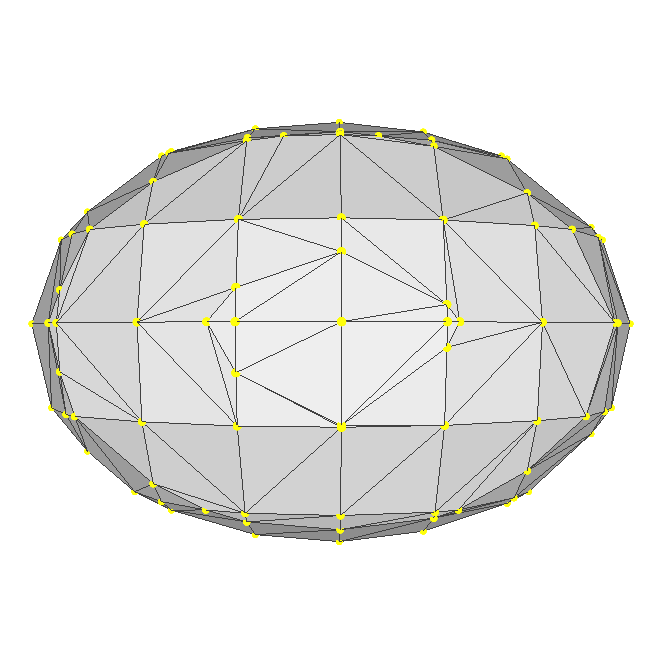

In [9]:
Image(filename = './init_obj/init1.png', width=200, height=200)

In [10]:
adj_1 = nx.adjacency_matrix(mesh.vertex_adjacency_graph, nodelist=range(len(coords_1)))
cheb_1 = chebyshev_polynomials(adj_1,1)
info['support']['stage1'] = cheb_1

edges_1 = mesh.edges_unique
edges_1 = edges_1[edges_1[:,1].argsort(kind='mergesort')]
edges_1 = edges_1[edges_1[:,0].argsort(kind='mergesort')]
info['unpool_idx']['stage1_2'] = edges_1

lap_1 = cal_lap_index(mesh.vertex_neighbors)
info['lap_idx']['stage1'] = lap_1

Calculating Chebyshev polynomials up to order 1...


## Stage 2 auxiliary matrix

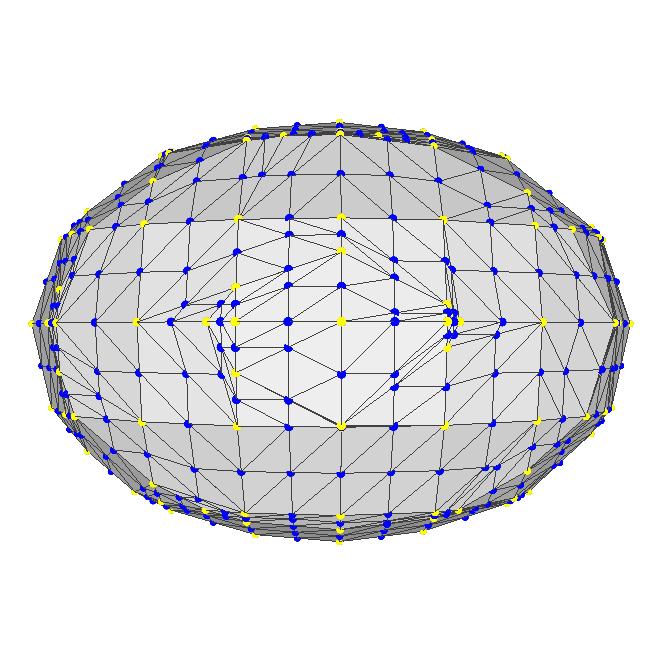

In [11]:
Image(filename = './init_obj/init2.png', width=200, height=200)

In [12]:
faces_1 = np.array(mesh.faces)

edges_2, faces_2 = unpool_face(faces_1, edges_1, coords_1)

tmp_1_2 = 0.5*(coords_1[info['unpool_idx']['stage1_2'][:,0]] + coords_1[info['unpool_idx']['stage1_2'][:,1]])
coords_2 = np.vstack([coords_1, tmp_1_2])

mesh2 = trimesh.Trimesh(vertices=coords_2, faces=faces_2, process=False)

adj_2 = nx.adjacency_matrix(mesh2.vertex_adjacency_graph, nodelist=range(len(coords_2)))
cheb_2 = chebyshev_polynomials(adj_2,1)
info['support']['stage2'] = cheb_2

edges_2 = edges_2[edges_2[:,1].argsort(kind='mergesort')]
edges_2 = edges_2[edges_2[:,0].argsort(kind='mergesort')]
info['unpool_idx']['stage2_3'] = edges_2

lap_2 = cal_lap_index(mesh2.vertex_neighbors)
info['lap_idx']['stage2'] = lap_2

Calculating Chebyshev polynomials up to order 1...


Save init2.obj, you can only save faces to get face2.obj

In [13]:
write_obj('./init_obj/init2.obj', coords_2, faces_2)

## Stage 3 auxiliary matrix

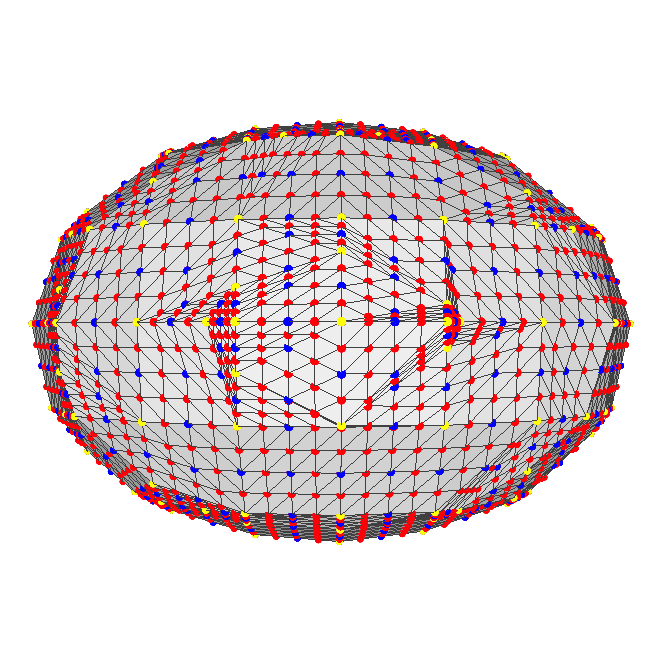

In [14]:
Image(filename = './init_obj/init3.png', width=200, height=200)

In [15]:
edges_3, faces_3 = unpool_face(faces_2, edges_2, coords_2)

tmp_2_3 = 0.5*(coords_2[info['unpool_idx']['stage2_3'][:,0]] + coords_2[info['unpool_idx']['stage2_3'][:,1]])
coords_3 = np.vstack([coords_2, tmp_2_3])

In [16]:
mesh3 = trimesh.Trimesh(vertices=coords_3, faces=faces_3, process=False)

In [17]:
adj_3 = nx.adjacency_matrix(mesh3.vertex_adjacency_graph, nodelist=range(len(coords_3)))
cheb_3 = chebyshev_polynomials(adj_3,1)
info['support']['stage3'] = cheb_3

Calculating Chebyshev polynomials up to order 1...


In [18]:
lap_3 = cal_lap_index(mesh3.vertex_neighbors)
info['lap_idx']['stage3'] = lap_3

Save init2.obj, you can only save faces to get face2.obj

In [19]:
write_obj('./init_obj/init3.obj', coords_3, faces_3)

## Dump .dat file

In [20]:
dat = [info['coords'],
       info['support']['stage1'],
       info['support']['stage2'],
       info['support']['stage3'],
       [info['unpool_idx']['stage1_2'], info['unpool_idx']['stage2_3']],
       [np.zeros((1,4), dtype=np.int32)]*3,
       [np.zeros((1,4))]*3,
       [info['lap_idx']['stage1'], info['lap_idx']['stage2'], info['lap_idx']['stage3']],
      ]
pickle.dump(dat, open("./init_obj/pixel2mesh_aux.dat","wb"), protocol=2)